In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
# this function generates an item bank, in case the user cannot provide one
from catsim.cat import generate_item_bank
# simulation package contains the Simulator and all abstract classes
from catsim.simulation import *
# initialization package contains different initial proficiency estimation strategies
from catsim.initialization import *
# selection package contains different item selection strategies
from catsim.selection import *
# estimation package contains different proficiency estimation methods
from catsim.estimation import *
# stopping package contains different stopping criteria for the CAT
from catsim.stopping import *
import catsim.plot as catplot
from catsim.irt import icc
from catsim.irt import detect_model


# this function generates an item bank, in case the user cannot provide one
from catsim.cat import generate_item_bank
# simulation package contains the Simulator and all abstract classes
from catsim.simulation import *
# initialization package contains different initial proficiency estimation strategies
from catsim.initialization import *
# selection package contains different item selection strategies
from catsim.selection import *
# estimation package contains different proficiency estimation methods
from catsim.estimation import *
# stopping package contains different stopping criteria for the CAT
from catsim.stopping import *
import catsim.plot as catplot
from catsim.irt import icc

C:\Users\patri\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def info_fisher(A, B, C, D, thetas):
    gg = 1 + np.exp(-D*A*(thetas - B))
    g = np.exp(-D*A*(thetas - B))
    info = ((1-C)*D*A)**2*g/ gg**2 / ((C*(g-1) - C**2*g + 1))
    return info


def KLP(blf,thetasB,probsB,logprobsB,log1_probsB,T):

    res = np.shape(probsB)
    
    nQ = res[0]
    nA = res[1]
    
    ind = np.argmin(abs(thetasB-T));
    
    probAcertar = np.tile(probsB[:,[ind]],(1,nA))
    logprobAcertar = np.tile(logprobsB[:,[ind]] ,(1,nA))
    log1_probAcertar = np.tile(log1_probsB[:,[ind]],(1,nA))
  

    klp = probAcertar*(logprobAcertar-logprobsB) + (1-probAcertar)*(log1_probAcertar-log1_probsB)
  
    retorno = blf@klp.T
    return retorno

# Base ENEM

In [3]:
alunos = pd.read_excel('C:/Users/patri/Desktop/CAT-GYM/file1000.xlsx')
param = pd.read_excel('C:/Users/patri/Desktop/CAT-GYM/Calibração/parametros.xlsx')
theta_original = np.loadtxt('Result_theta_original-base1000.txt')

In [13]:
# repete = 200;
# nA = 25;

# repete = 1;
# nA = 50;

repete = 2;
nA = len(alunos);

nQ = len(param.iloc[0:45,1]);
maxnQ = min(45,nQ);

# Maximum Likelihood Parameters 

rateGrow = 0.25;
maxGrow = 2;

estimator = 3
estName = ['EAP','MAP','ML']
base = 1
# baseName = ['norm','uni','peak']
shift = 1

nSC = 6;

# thetasA = np.random.randn(nA)
thetasA = theta_original

As = param.iloc[0:45,1].to_numpy()
Bs = param.iloc[0:45,2].to_numpy()
Cs = param.iloc[0:45,3].to_numpy()
D = np.array(1,ndmin=1)

thetasB = np.arange(-4,4,0.001)
nB = len(thetasB)

blf0 =  norm.pdf(thetasB)
blf0 = blf0/np.sum(blf0)

probsB = np.zeros((nQ,nB))
probsA = np.zeros((nQ,nA))
infos = np.zeros((nQ,nB))


for q in np.arange(0,nQ):
    probsA[q,:] = (Cs[q] + (1-Cs[q])/( 1 + np.exp(-D*As[q]*( thetasA - Bs[q]  ) )   ))
    probsB[q,:] = (Cs[q] + (1-Cs[q])/( 1 + np.exp(-D*As[q]*( thetasB - Bs[q]  ) )   ))
    infos[q,:] =  ((1-Cs[q])*D*As[q]*np.exp(-D*As[q]*( thetasB - Bs[q]  ) )/ (1 + np.exp(-D * As[q] * ( thetasB - Bs[q]  ) ))**2 )**2/( probsB[q,:]*(1-probsB[q,:]) )
    infos[q,:] =  info_fisher(As[q],Bs[q],Cs[q],D,thetasB)


logprobsB = np.log(probsB);
log1_probsB = np.log(1-probsB);

In [14]:
globalMSE = []
globalthetaB = []
for sc in range(0,nSC):
  globalMSE.append([])
  globalthetaB.append([])

globalthetasA = []

# respA = probsA > np.random.rand(nQ,nA)
respA = (alunos.iloc[:,0:45].to_numpy()).T

thetaB = np.zeros((nA,maxnQ+1))
    
infosTotal = np.zeros((nQ,len(thetasB)));

for q in range(0,nQ):
    infosTotal[q,:] = info_fisher(As[q],Bs[q],Cs[q],D,thetasB);

for sc in range(0,nSC):
  
  print(sc)
  for a in range(0,nA):

    if np.remainder(a+1,100) == 0:
        print(sc,a/nA)

    blf = blf0
    applied = np.zeros(nQ)

    for q in np.arange(0,maxnQ):

      if estimator == 1:
        # EAP
        T = np.sum(blf*thetasB)
      elif estimator == 2:
        # MAP
        aux = np.argmax(blf)
        T = thetasB[0,aux]
      elif estimator == 3:
        # ML
        if q>0:
          qs = np.flatnonzero(np.isinf(applied))
          if np.min(  respA[qs, a] == 0 ):     # min (python) = all (matlab)
            T = np.max([-maxGrow,-len(qs)*rateGrow])
          elif np.min(  respA[qs, a] == 1 ):
            T = np.min([maxGrow,len(qs)*rateGrow])
          else:
            aux = np.argmax(blf/blf0)
            T = thetasB[aux]
        else:
          T = 0

      if sc == 0:
        inicio = time.time()
        
        I = info_fisher(As,Bs,Cs,D,T)
        vv = np.max(I+applied)
        qq = np.argmax(I+applied)
        
        fim = time.time()
        print(fim - inicio)
        
      elif sc == 1:
        inicio = time.time()
        
        aux = np.flatnonzero(applied==0)
        qq = aux[np.random.randint(len(aux))]

        fim = time.time()
        print(fim - inicio)
        
      elif sc == 2:
        inicio = time.time()
        
        kl = KLP(blf/blf0,thetasB,probsB,logprobsB,log1_probsB,T)
        vv = np.max(kl+applied)
        qq = np.argmax(kl+applied)
        
        fim = time.time()
        print(fim - inicio)

      elif sc == 3:
        inicio = time.time()
        
        klp = KLP(blf,thetasB,probsB,logprobsB,log1_probsB,T)
        vv = np.max(klp+applied)
        qq = np.argmax(klp+applied)
        
        fim = time.time()
        print(fim - inicio)

      elif sc == 4:
        inicio = time.time()
        
        mlwi = (blf/blf0)@infosTotal.T
        vv = np.max(mlwi+applied)
        qq = np.argmax(mlwi+applied)

        fim = time.time()
        print(fim - inicio)
        
      elif sc == 5:
        inicio = time.time()
        
        mpwi = blf@infosTotal.T
        vv = np.max(mpwi+applied)
        qq = np.argmax(mpwi+applied)

        fim = time.time()
        print(fim - inicio)
        
      # elif sc == 6:
#         inicio = time.time()
    
        # er = ExpRed(blf,thetasB,probsB)
        # vv = np.max(er+applied)
        # qq = np.argmax(er+applied)
        
#         fim = time.time()
#         print(fim - inicio)

      if respA[qq,a] == 1:
          blf = blf*probsB[qq,:]
      else:
          blf = blf*(1-probsB[qq,:])

      blf = blf/sum(blf);
      thetaB[a,q] = T;
      applied[qq] = -np.inf;

    if estimator == 1:
      # EAP
      T = np.sum(blf*thetasB)
    elif estimator == 2:
      # MAP
      aux = np.argmax(blf)
      T = thetasB[0,aux]
    elif estimator == 3:
      # ML
      if q>0:
        qs = np.flatnonzero(np.isinf(applied))
        if np.min(  respA[qs, a] == 0 ):     # min (python) = all (matlab)
          T = np.max([-maxGrow,-len(qs)*rateGrow])
        elif np.min(  respA[qs, a] == 1 ):
          T = np.min([maxGrow,len(qs)*rateGrow])
        else:
          aux = np.argmax(blf/blf0)
          T = thetasB[aux]
      else:
        T = 0
          
    thetaB[a,q+1] = T

  MSE = (thetaB-np.tile(thetasA,(maxnQ+1,1)).T)**2
  globalMSE[sc].append(MSE)
  globalthetaB[sc].append(thetaB)
  globalthetasA.append(thetasA)

0
0 0.099
0 0.199
0 0.299
0 0.399
0 0.499
0 0.599
0 0.699
0 0.799
0 0.899
0 0.999
1
1 0.099
1 0.199
1 0.299
1 0.399
1 0.499
1 0.599
1 0.699
1 0.799
1 0.899
1 0.999
2
2 0.099
2 0.199
2 0.299
2 0.399
2 0.499
2 0.599
2 0.699
2 0.799
2 0.899
2 0.999
3
3 0.099
3 0.199
3 0.299
3 0.399
3 0.499
3 0.599
3 0.699
3 0.799
3 0.899
3 0.999
4
4 0.099
4 0.199
4 0.299
4 0.399
4 0.499
4 0.599
4 0.699
4 0.799
4 0.899
4 0.999
5
5 0.099
5 0.199
5 0.299
5 0.399
5 0.499
5 0.599
5 0.699
5 0.799
5 0.899
5 0.999


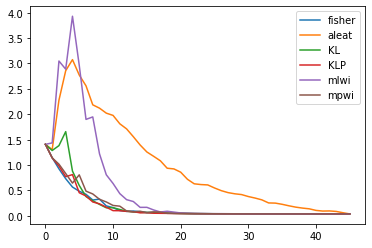

In [16]:
for sc in range(nSC):
  plt.plot(np.mean(globalMSE[sc][0],axis=0))
plt.gca().legend(("fisher","aleat","KL","KLP","mlwi","mpwi"))

In [17]:
globalMSE

[[array([[5.87295269e-01, 2.66619307e-01, 7.09433464e-02, ...,
          4.20004957e-07, 4.20004957e-07, 1.23849169e-07],
         [3.59826307e+00, 2.71230866e+00, 1.95135425e+00, ...,
          8.31405386e-09, 8.31405386e-09, 8.31405386e-09],
         [4.91644176e-01, 2.03557462e-01, 3.35441860e-01, ...,
          6.83221095e-07, 3.00773082e-08, 3.00773082e-08],
         ...,
         [2.49014859e+00, 1.76363836e+00, 1.16212813e+00, ...,
          4.18872711e-10, 4.18872711e-10, 4.18872711e-10],
         [3.16860155e-01, 9.79084917e-02, 5.42439595e-02, ...,
          9.34577238e-09, 9.34577238e-09, 9.34577238e-09],
         [1.18826755e-02, 1.98788327e-02, 1.68800234e-04, ...,
          5.90681059e-11, 5.90681059e-11, 5.90681059e-11]])],
 [array([[5.87295269e-01, 2.66619307e-01, 1.21362849e+00, ...,
          1.65226624e-03, 2.95413144e-03, 1.23849169e-07],
         [3.59826307e+00, 2.71230866e+00, 1.95135425e+00, ...,
          3.58906654e-03, 3.58906654e-03, 8.31405386e-09],
       

In [36]:
np.sqrt(np.mean((globalMSE[1]),axis=0))

array([[7.66351922e-01, 5.16351922e-01, 1.10164808e+00, ...,
        4.06480779e-02, 5.43519221e-02, 3.51922106e-04],
       [1.89690882e+00, 1.64690882e+00, 1.39690882e+00, ...,
        5.99088186e-02, 5.99088186e-02, 9.11814337e-05],
       [7.01173428e-01, 9.51173428e-01, 1.20117343e+00, ...,
        1.73428107e-04, 4.82657189e-03, 1.73428107e-04],
       ...,
       [1.57802047e+00, 1.32802047e+00, 4.15602047e+00, ...,
        3.40204664e-02, 1.02046638e-03, 2.04663800e-05],
       [5.62903326e-01, 8.12903326e-01, 1.57690333e+00, ...,
        3.09667354e-03, 3.09667354e-03, 9.66735350e-05],
       [1.09007686e-01, 3.59007686e-01, 6.09007686e-01, ...,
        3.30076856e-02, 3.40076856e-02, 7.68557778e-06]])

# Salva saídas

In [53]:
import pickle
pickle.dump(globalMSE, open('globalMSE_1000.pkl', 'wb'))
#np.savetxt('globalMSE_1000', globalMSE)
pickle.dump(globalthetaB, open('globalthetaB_1000.pkl', 'wb'))
#np.savetxt('globalthetaB_1000', globalthetaB)
pickle.dump(globalthetasA, open('globalthetasA_1000.pkl', 'wb'))
#np.savetxt('globalthetasA_1000', globalthetasA)

# Grupos

In [21]:
np.sort(theta_original)

array([-3.22438901e+00, -3.22438900e+00, -3.22438889e+00, -3.22438878e+00,
       -3.22438862e+00, -3.22438851e+00, -3.22438829e+00, -3.22438828e+00,
       -3.22438811e+00, -3.22438805e+00, -3.22438797e+00, -3.22438786e+00,
       -3.22438771e+00, -3.22438746e+00, -3.22438742e+00, -3.22438725e+00,
       -3.22438724e+00, -3.22438711e+00, -3.22438694e+00, -3.22438693e+00,
       -3.22438690e+00, -3.22438679e+00, -3.22438673e+00, -3.22438665e+00,
       -3.22438657e+00, -3.22438647e+00, -3.22438645e+00, -3.22438643e+00,
       -3.22438642e+00, -3.22438637e+00, -3.22438627e+00, -3.22438625e+00,
       -3.22438624e+00, -3.22438601e+00, -3.03292989e+00, -2.97233199e+00,
       -2.95539763e+00, -2.95107560e+00, -2.94238701e+00, -2.82417065e+00,
       -2.61419392e+00, -2.58746452e+00, -2.55871302e+00, -2.52267341e+00,
       -2.38376721e+00, -2.17733743e+00, -2.17471860e+00, -2.16516626e+00,
       -2.16127231e+00, -2.15962637e+00, -2.15807202e+00, -2.15704877e+00,
       -2.13950524e+00, -

In [22]:
z = np.argsort(theta_original)
theta_orig = theta_original[z[0:99993]]
theta_orig

array([-3.22438901e+00, -3.22438900e+00, -3.22438889e+00, -3.22438878e+00,
       -3.22438862e+00, -3.22438851e+00, -3.22438829e+00, -3.22438828e+00,
       -3.22438811e+00, -3.22438805e+00, -3.22438797e+00, -3.22438786e+00,
       -3.22438771e+00, -3.22438746e+00, -3.22438742e+00, -3.22438725e+00,
       -3.22438724e+00, -3.22438711e+00, -3.22438694e+00, -3.22438693e+00,
       -3.22438690e+00, -3.22438679e+00, -3.22438673e+00, -3.22438665e+00,
       -3.22438657e+00, -3.22438647e+00, -3.22438645e+00, -3.22438643e+00,
       -3.22438642e+00, -3.22438637e+00, -3.22438627e+00, -3.22438625e+00,
       -3.22438624e+00, -3.22438601e+00, -3.03292989e+00, -2.97233199e+00,
       -2.95539763e+00, -2.95107560e+00, -2.94238701e+00, -2.82417065e+00,
       -2.61419392e+00, -2.58746452e+00, -2.55871302e+00, -2.52267341e+00,
       -2.38376721e+00, -2.17733743e+00, -2.17471860e+00, -2.16516626e+00,
       -2.16127231e+00, -2.15962637e+00, -2.15807202e+00, -2.15704877e+00,
       -2.13950524e+00, -

In [23]:
n = 5
splited = []
len_l = len(theta_orig)
for i in range(n):
    start = int(i*len_l/n)
    end = int((i+1)*len_l/n)
    splited.append(theta_orig[start:end])
print(splited)

[array([-3.22438901, -3.224389  , -3.22438889, -3.22438878, -3.22438862,
       -3.22438851, -3.22438829, -3.22438828, -3.22438811, -3.22438805,
       -3.22438797, -3.22438786, -3.22438771, -3.22438746, -3.22438742,
       -3.22438725, -3.22438724, -3.22438711, -3.22438694, -3.22438693,
       -3.2243869 , -3.22438679, -3.22438673, -3.22438665, -3.22438657,
       -3.22438647, -3.22438645, -3.22438643, -3.22438642, -3.22438637,
       -3.22438627, -3.22438625, -3.22438624, -3.22438601, -3.03292989,
       -2.97233199, -2.95539763, -2.9510756 , -2.94238701, -2.82417065,
       -2.61419392, -2.58746452, -2.55871302, -2.52267341, -2.38376721,
       -2.17733743, -2.1747186 , -2.16516626, -2.16127231, -2.15962637,
       -2.15807202, -2.15704877, -2.13950524, -2.12981384, -2.12758151,
       -2.11046003, -2.10454061, -2.07992654, -2.07536952, -2.05968341,
       -2.01222936, -1.98559594, -1.95487023, -1.93071331, -1.89690882,
       -1.84042056, -1.8376539 , -1.80942427, -1.80628122, -1.7

In [24]:
n = 5
splited1 = []
len_l = len(z)
for i in range(n):
    start = int(i*len_l/n)
    end = int((i+1)*len_l/n)
    splited1.append(z[start:end])
print(splited1)

[array([  7, 430, 279, 717, 622, 927, 193, 777, 544,  55, 380, 828, 786,
       840, 883, 903,  66, 699,  80, 811, 734, 814, 327, 101, 226, 124,
       913, 587, 888, 317, 817, 800,  86, 620, 928, 241, 877, 489, 215,
         3, 314, 359, 304, 276,  18, 679, 558, 321, 212, 160,   6, 874,
       456, 189, 785, 705, 263, 924, 130, 686, 396, 227, 412, 531,   1,
       940,  69, 303, 853,  21, 331,  93, 480, 448, 156, 780, 460, 592,
       799, 445, 368, 444, 132, 944, 603, 318, 164, 202, 315, 907, 370,
        57, 283, 337, 813, 901, 654, 719, 208, 997, 879, 416, 884,  78,
       968, 695, 260, 296, 573, 868, 763,  84, 724, 976, 197, 820, 898,
       184, 249,  97, 818, 696, 108, 675, 672, 810, 575, 301, 268,  85,
       683, 330, 475, 353, 252, 423, 566, 819, 858, 486, 259, 850, 474,
       272, 194,  95, 894, 577, 341, 525, 742, 504, 591, 723,  30,  17,
       401, 745, 464, 594, 935, 242,   4, 238, 608,  24, 733, 180, 975,
       251, 264, 351, 273, 409, 987, 920, 352, 228, 509, 580, 2

In [26]:
ind0 = splited1[0]
ind1 = splited1[1]
ind2 = splited1[2]
ind3 = splited1[3]
ind4 = splited1[4]

In [56]:
import pickle
f = open('globalMSE_1000.pkl', 'rb')   # 'r' for reading; can be omitted
globalMSE_1000 = pickle.load(f)  

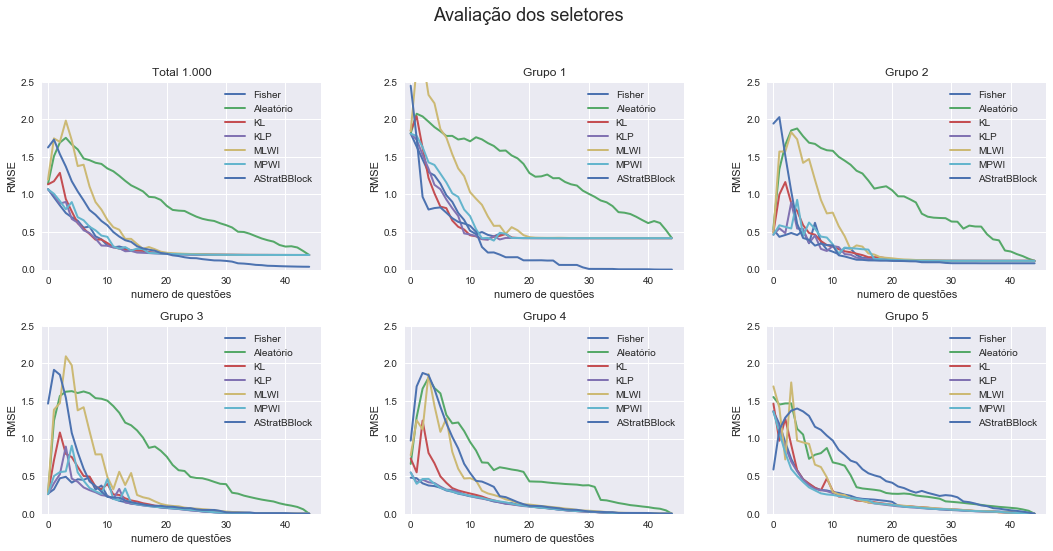

In [121]:
plt.style.use("seaborn")

plt.figure(figsize = ((18, 8)))

a = globalMSE_1000[0]
b = globalMSE_1000[1]
c = globalMSE_1000[2]
d = globalMSE_1000[3]
e = globalMSE_1000[4]
f = globalMSE_1000[5]
g = np.loadtxt('Result_AStratBBlockSelector_theta_orig_1000.txt')

plt.subplot(2, 3, 1)
# define a legenda e tamanho de linhas
plt.plot(range(0, 45), np.sqrt(np.mean(a[0],axis=0)).T[1:46], label='Fisher', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(b[0],axis=0)).T[1:46], label='Aleatório', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(c[0],axis=0)).T[1:46], label='KL', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(d[0],axis=0)).T[1:46], label='KLP', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(e[0],axis=0)).T[1:46], label='MLWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(f[0],axis=0)).T[1:46], label='MPWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean((g[1:,:])**2,axis=0)), label='AStratBBlock', linewidth=2)
plt.axis([-1, 46, 0, 2.5])

plt.xlabel('numero de questões')
plt.ylabel('RMSE')
plt.title("Total 1.000")

# Exibe a legenda e por padrão usa o label de cada plot.
plt.legend()

g_new = g[1:,:]

##################################
a_base0 = a[0][ind0,:]
b_base0 = b[0][ind0,:]
c_base0 = c[0][ind0,:]
d_base0 = d[0][ind0,:]
e_base0 = e[0][ind0,:]
f_base0 = f[0][ind0,:]
g_base0 = g_new[ind0,:]

plt.subplot(2, 3, 2)
# define a legenda e tamanho de linhas
plt.plot(range(0, 45), np.sqrt(np.mean(a_base0,axis=0)).T[1:46], label='Fisher', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(b_base0,axis=0)).T[1:46], label='Aleatório', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(c_base0,axis=0)).T[1:46], label='KL', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(d_base0,axis=0)).T[1:46], label='KLP', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(e_base0,axis=0)).T[1:46], label='MLWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(f_base0,axis=0)).T[1:46], label='MPWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean((g_base0)**2,axis=0)), label='AStratBBlock', linewidth=2)
plt.axis([-1, 46, 0, 2.5])

plt.xlabel('numero de questões')
plt.ylabel('RMSE')
plt.title("Grupo 1")

# Exibe a legenda e por padrão usa o label de cada plot.
plt.legend()


#######################################################################################################

a_base1 = a[0][ind1,:]
b_base1 = b[0][ind1,:]
c_base1 = c[0][ind1,:]
d_base1 = d[0][ind1,:]
e_base1 = e[0][ind1,:]
f_base1 = f[0][ind1,:]
g_base1 = g_new[ind1,:]

plt.subplot(2, 3, 3)
# define a legenda e tamanho de linhas
plt.plot(range(0, 45), np.sqrt(np.mean(a_base1,axis=0)).T[1:46], label='Fisher', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(b_base1,axis=0)).T[1:46], label='Aleatório', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(c_base1,axis=0)).T[1:46], label='KL', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(d_base1,axis=0)).T[1:46], label='KLP', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(e_base1,axis=0)).T[1:46], label='MLWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(f_base1,axis=0)).T[1:46], label='MPWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean((g_base1)**2,axis=0)), label='AStratBBlock', linewidth=2)
plt.axis([-1, 46, 0, 2.5])

plt.xlabel('numero de questões')
plt.ylabel('RMSE')
plt.title("Grupo 2")

# Exibe a legenda e por padrão usa o label de cada plot.
plt.legend()

#######################################################################################################

a_base2 = a[0][ind2,:]
b_base2 = b[0][ind2,:]
c_base2 = c[0][ind2,:]
d_base2 = d[0][ind2,:]
e_base2 = e[0][ind2,:]
f_base2 = f[0][ind2,:]
g_base2 = g_new[ind2,:]

plt.subplot(2, 3, 4)
# define a legenda e tamanho de linhas
plt.plot(range(0, 45), np.sqrt(np.mean(a_base2,axis=0)).T[1:46], label='Fisher', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(b_base2,axis=0)).T[1:46], label='Aleatório', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(c_base2,axis=0)).T[1:46], label='KL', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(d_base2,axis=0)).T[1:46], label='KLP', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(e_base2,axis=0)).T[1:46], label='MLWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(f_base2,axis=0)).T[1:46], label='MPWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean((g_base2)**2,axis=0)), label='AStratBBlock', linewidth=2)
plt.axis([-1, 46, 0, 2.5])

plt.xlabel('numero de questões')
plt.ylabel('RMSE')
plt.title("Grupo 3")

# Exibe a legenda e por padrão usa o label de cada plot.
plt.legend()

#######################################################################################################

a_base3 = a[0][ind3,:]
b_base3 = b[0][ind3,:]
c_base3 = c[0][ind3,:]
d_base3 = d[0][ind3,:]
e_base3 = e[0][ind3,:]
f_base3 = f[0][ind3,:]
g_base3 = g_new[ind3,:]

plt.subplot(2, 3, 5)
# define a legenda e tamanho de linhas
plt.plot(range(0, 45), np.sqrt(np.mean(a_base3,axis=0)).T[1:46], label='Fisher', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(b_base3,axis=0)).T[1:46], label='Aleatório', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(c_base3,axis=0)).T[1:46], label='KL', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(d_base3,axis=0)).T[1:46], label='KLP', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(e_base3,axis=0)).T[1:46], label='MLWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(f_base3,axis=0)).T[1:46], label='MPWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean((g_base3)**2,axis=0)), label='AStratBBlock', linewidth=2)
plt.axis([-1, 46, 0, 2.5])

plt.xlabel('numero de questões')
plt.ylabel('RMSE')
plt.title("Grupo 4")

# Exibe a legenda e por padrão usa o label de cada plot.
plt.legend()



#######################################################################################################

a_base4 = a[0][ind4,:]
b_base4 = b[0][ind4,:]
c_base4 = c[0][ind4,:]
d_base4 = d[0][ind4,:]
e_base4 = e[0][ind4,:]
f_base4 = f[0][ind4,:]
g_base4 = g_new[ind4,:]

plt.subplot(2, 3, 6)
# define a legenda e tamanho de linhas
plt.plot(range(0, 45), np.sqrt(np.mean(a_base4,axis=0)).T[1:46], label='Fisher', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(b_base4,axis=0)).T[1:46], label='Aleatório', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(c_base4,axis=0)).T[1:46], label='KL', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(d_base4,axis=0)).T[1:46], label='KLP', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(e_base4,axis=0)).T[1:46], label='MLWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(f_base4,axis=0)).T[1:46], label='MPWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean((g_base4)**2,axis=0)), label='AStratBBlock', linewidth=2)
plt.axis([-1, 46, 0, 2.5])

plt.xlabel('numero de questões')
plt.ylabel('RMSE')
plt.title("Grupo 5")

# Exibe a legenda e por padrão usa o label de cada plot.
plt.legend()


plt.suptitle("Avaliação dos seletores", fontsize = 18)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.85, wspace=0.3, hspace=0.3)


plt.show()

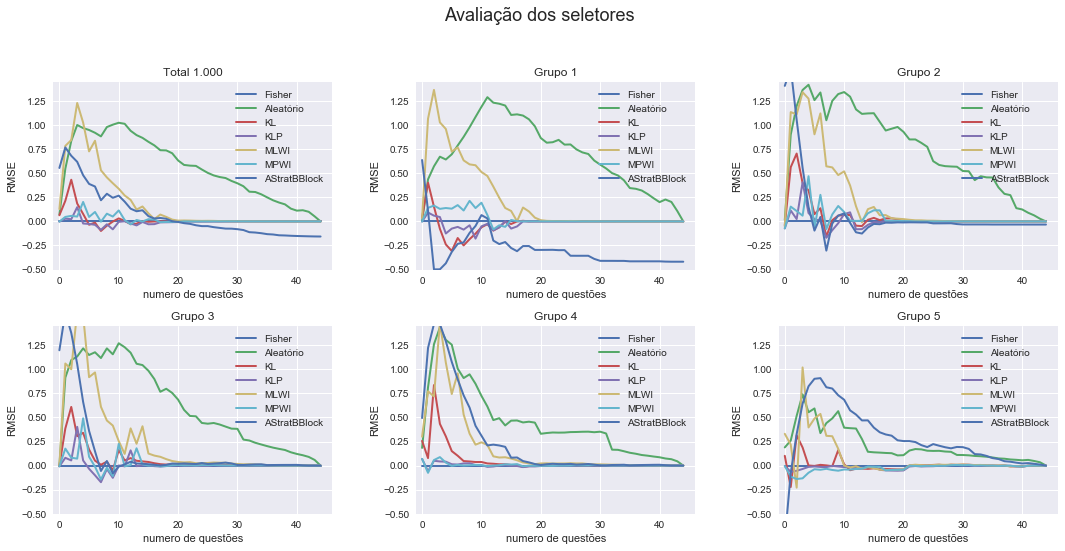

In [123]:
plt.style.use("seaborn")

plt.figure(figsize = ((18, 8)))

a = globalMSE_1000[0]
b = globalMSE_1000[1]
c = globalMSE_1000[2]
d = globalMSE_1000[3]
e = globalMSE_1000[4]
f = globalMSE_1000[5]
g = np.loadtxt('Result_AStratBBlockSelector_theta_orig_1000.txt')

plt.subplot(2, 3, 1)
# define a legenda e tamanho de linhas
plt.plot(range(0, 45), np.sqrt(np.mean(a[0],axis=0)).T[1:46]-np.sqrt(np.mean(a[0],axis=0)).T[1:46], label='Fisher', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(b[0],axis=0)).T[1:46]-np.sqrt(np.mean(a[0],axis=0)).T[1:46], label='Aleatório', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(c[0],axis=0)).T[1:46]-np.sqrt(np.mean(a[0],axis=0)).T[1:46], label='KL', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(d[0],axis=0)).T[1:46]-np.sqrt(np.mean(a[0],axis=0)).T[1:46], label='KLP', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(e[0],axis=0)).T[1:46]-np.sqrt(np.mean(a[0],axis=0)).T[1:46], label='MLWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(f[0],axis=0)).T[1:46]-np.sqrt(np.mean(a[0],axis=0)).T[1:46], label='MPWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean((g[1:,:])**2,axis=0))-np.sqrt(np.mean(a[0],axis=0)).T[1:46], label='AStratBBlock', linewidth=2)
plt.axis([-1, 46, -0.5, 1.45])

plt.xlabel('numero de questões')
plt.ylabel('RMSE')
plt.title("Total 1.000")

# Exibe a legenda e por padrão usa o label de cada plot.
plt.legend()

g_new = g[1:,:]

##################################
a_base0 = a[0][ind0,:]
b_base0 = b[0][ind0,:]
c_base0 = c[0][ind0,:]
d_base0 = d[0][ind0,:]
e_base0 = e[0][ind0,:]
f_base0 = f[0][ind0,:]
g_base0 = g_new[ind0,:]

plt.subplot(2, 3, 2)
# define a legenda e tamanho de linhas
plt.plot(range(0, 45), np.sqrt(np.mean(a_base0,axis=0)).T[1:46]-np.sqrt(np.mean(a_base0,axis=0)).T[1:46], label='Fisher', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(b_base0,axis=0)).T[1:46]-np.sqrt(np.mean(a_base0,axis=0)).T[1:46], label='Aleatório', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(c_base0,axis=0)).T[1:46]-np.sqrt(np.mean(a_base0,axis=0)).T[1:46], label='KL', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(d_base0,axis=0)).T[1:46]-np.sqrt(np.mean(a_base0,axis=0)).T[1:46], label='KLP', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(e_base0,axis=0)).T[1:46]-np.sqrt(np.mean(a_base0,axis=0)).T[1:46], label='MLWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(f_base0,axis=0)).T[1:46]-np.sqrt(np.mean(a_base0,axis=0)).T[1:46], label='MPWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean((g_base0)**2,axis=0))-np.sqrt(np.mean(a_base0,axis=0)).T[1:46], label='AStratBBlock', linewidth=2)
plt.axis([-1, 46, -0.5, 1.45])

plt.xlabel('numero de questões')
plt.ylabel('RMSE')
plt.title("Grupo 1")

# Exibe a legenda e por padrão usa o label de cada plot.
plt.legend()


#######################################################################################################

a_base1 = a[0][ind1,:]
b_base1 = b[0][ind1,:]
c_base1 = c[0][ind1,:]
d_base1 = d[0][ind1,:]
e_base1 = e[0][ind1,:]
f_base1 = f[0][ind1,:]
g_base1 = g_new[ind1,:]

plt.subplot(2, 3, 3)
# define a legenda e tamanho de linhas
plt.plot(range(0, 45), np.sqrt(np.mean(a_base1,axis=0)).T[1:46]-np.sqrt(np.mean(a_base1,axis=0)).T[1:46], label='Fisher', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(b_base1,axis=0)).T[1:46]-np.sqrt(np.mean(a_base1,axis=0)).T[1:46], label='Aleatório', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(c_base1,axis=0)).T[1:46]-np.sqrt(np.mean(a_base1,axis=0)).T[1:46], label='KL', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(d_base1,axis=0)).T[1:46]-np.sqrt(np.mean(a_base1,axis=0)).T[1:46], label='KLP', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(e_base1,axis=0)).T[1:46]-np.sqrt(np.mean(a_base1,axis=0)).T[1:46], label='MLWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(f_base1,axis=0)).T[1:46]-np.sqrt(np.mean(a_base1,axis=0)).T[1:46], label='MPWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean((g_base1)**2,axis=0))-np.sqrt(np.mean(a_base1,axis=0)).T[1:46], label='AStratBBlock', linewidth=2)
plt.axis([-1, 46, -0.5, 1.45])

plt.xlabel('numero de questões')
plt.ylabel('RMSE')
plt.title("Grupo 2")

# Exibe a legenda e por padrão usa o label de cada plot.
plt.legend()

#######################################################################################################

a_base2 = a[0][ind2,:]
b_base2 = b[0][ind2,:]
c_base2 = c[0][ind2,:]
d_base2 = d[0][ind2,:]
e_base2 = e[0][ind2,:]
f_base2 = f[0][ind2,:]
g_base2 = g_new[ind2,:]

plt.subplot(2, 3, 4)
# define a legenda e tamanho de linhas
plt.plot(range(0, 45), np.sqrt(np.mean(a_base2,axis=0)).T[1:46]-np.sqrt(np.mean(a_base2,axis=0)).T[1:46], label='Fisher', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(b_base2,axis=0)).T[1:46]-np.sqrt(np.mean(a_base2,axis=0)).T[1:46], label='Aleatório', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(c_base2,axis=0)).T[1:46]-np.sqrt(np.mean(a_base2,axis=0)).T[1:46], label='KL', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(d_base2,axis=0)).T[1:46]-np.sqrt(np.mean(a_base2,axis=0)).T[1:46], label='KLP', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(e_base2,axis=0)).T[1:46]-np.sqrt(np.mean(a_base2,axis=0)).T[1:46], label='MLWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(f_base2,axis=0)).T[1:46]-np.sqrt(np.mean(a_base2,axis=0)).T[1:46], label='MPWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean((g_base2)**2,axis=0))-np.sqrt(np.mean(a_base2,axis=0)).T[1:46], label='AStratBBlock', linewidth=2)
plt.axis([-1, 46, -0.5, 1.45])

plt.xlabel('numero de questões')
plt.ylabel('RMSE')
plt.title("Grupo 3")

# Exibe a legenda e por padrão usa o label de cada plot.
plt.legend()

#######################################################################################################

a_base3 = a[0][ind3,:]
b_base3 = b[0][ind3,:]
c_base3 = c[0][ind3,:]
d_base3 = d[0][ind3,:]
e_base3 = e[0][ind3,:]
f_base3 = f[0][ind3,:]
g_base3 = g_new[ind3,:]

plt.subplot(2, 3, 5)
# define a legenda e tamanho de linhas
plt.plot(range(0, 45), np.sqrt(np.mean(a_base3,axis=0)).T[1:46]-np.sqrt(np.mean(a_base3,axis=0)).T[1:46], label='Fisher', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(b_base3,axis=0)).T[1:46]-np.sqrt(np.mean(a_base3,axis=0)).T[1:46], label='Aleatório', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(c_base3,axis=0)).T[1:46]-np.sqrt(np.mean(a_base3,axis=0)).T[1:46], label='KL', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(d_base3,axis=0)).T[1:46]-np.sqrt(np.mean(a_base3,axis=0)).T[1:46], label='KLP', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(e_base3,axis=0)).T[1:46]-np.sqrt(np.mean(a_base3,axis=0)).T[1:46], label='MLWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(f_base3,axis=0)).T[1:46]-np.sqrt(np.mean(a_base3,axis=0)).T[1:46], label='MPWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean((g_base3)**2,axis=0))-np.sqrt(np.mean(a_base3,axis=0)).T[1:46], label='AStratBBlock', linewidth=2)
plt.axis([-1, 46, -0.5, 1.45])

plt.xlabel('numero de questões')
plt.ylabel('RMSE')
plt.title("Grupo 4")

# Exibe a legenda e por padrão usa o label de cada plot.
plt.legend()



#######################################################################################################

a_base4 = a[0][ind4,:]
b_base4 = b[0][ind4,:]
c_base4 = c[0][ind4,:]
d_base4 = d[0][ind4,:]
e_base4 = e[0][ind4,:]
f_base4 = f[0][ind4,:]
g_base4 = g_new[ind4,:]

plt.subplot(2, 3, 6)
# define a legenda e tamanho de linhas
plt.plot(range(0, 45), np.sqrt(np.mean(a_base4,axis=0)).T[1:46]-np.sqrt(np.mean(a_base4,axis=0)).T[1:46], label='Fisher', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(b_base4,axis=0)).T[1:46]-np.sqrt(np.mean(a_base4,axis=0)).T[1:46], label='Aleatório', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(c_base4,axis=0)).T[1:46]-np.sqrt(np.mean(a_base4,axis=0)).T[1:46], label='KL', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(d_base4,axis=0)).T[1:46]-np.sqrt(np.mean(a_base4,axis=0)).T[1:46], label='KLP', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(e_base4,axis=0)).T[1:46]-np.sqrt(np.mean(a_base4,axis=0)).T[1:46], label='MLWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean(f_base4,axis=0)).T[1:46]-np.sqrt(np.mean(a_base4,axis=0)).T[1:46], label='MPWI', linewidth=2)
plt.plot(range(0, 45), np.sqrt(np.mean((g_base4)**2,axis=0))-np.sqrt(np.mean(a_base4,axis=0)).T[1:46], label='AStratBBlock', linewidth=2)
plt.axis([-1, 46, -0.5, 1.45])

plt.xlabel('numero de questões')
plt.ylabel('RMSE')
plt.title("Grupo 5")

# Exibe a legenda e por padrão usa o label de cada plot.
plt.legend()


plt.suptitle("Avaliação dos seletores", fontsize = 18)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.85, wspace=0.3, hspace=0.3)


plt.show()

# Comparando estimadores do pacote com os implementados

In [148]:
import pickle
f = open('globalthetaB_1000.pkl', 'rb')   # 'r' for reading; can be omitted
globalthetaB_1000 = pickle.load(f)
globalthetaB_1000[0][0]

array([[ 0.   ,  0.25 ,  0.766, ...,  0.767,  0.767,  0.766],
       [ 0.   , -0.25 , -0.5  , ..., -1.897, -1.897, -1.897],
       [ 0.   , -0.25 ,  0.122, ...,  0.702,  0.701,  0.701],
       ...,
       [ 0.   , -0.25 , -0.5  , ..., -1.578, -1.578, -1.578],
       [ 0.   , -0.25 , -0.5  , ..., -0.563, -0.563, -0.563],
       [ 0.   , -0.25 ,  0.122, ...,  0.109,  0.109,  0.109]])

In [86]:
np.shape(globalthetaB_1000)

(6, 1, 1000, 46)

In [99]:
theta_original = np.loadtxt('Result_theta_original-base1000.txt')
theta_original[0]

0.7663519221053628

In [153]:
n=1000
diferenca = []
for i in range(n):
    dif = abs(theta_original[i] - globalthetaB_1000[0][0][i][45])
    diferenca.append(dif)
print(diferenca)

[0.00035192210588774753, 9.118143374697851e-05, 0.00017342810675124998, 0.00017065152568918052, 7.619080700571601e-06, 0.000372387070877056, 7.202377795101356e-05, 0.7756109929747392, 0.0003888511933008987, 0.0004625463582961231, 0.00034868746067917566, 5.0366840640081456e-05, 0.00015398212446876558, 0.00045396667324348883, 0.00045612268852857074, 0.0002627210646119482, 2.5418244655739386e-05, 6.083301236037286e-05, 0.00023278540453475216, 0.0004687663134747555, 0.00018822487290454104, 3.628337627725742e-05, 0.00013874126788748775, 0.00027589636757302527, 0.00020603429900867276, 0.00037202314768847167, 0.0004944649534888712, 0.0001394779701577864, 0.00024407629356382188, 0.0002876130815735456, 0.00036875953574022624, 0.000499748547901413, 0.0002674817783694383, 0.00011950162729584823, 0.00028750438637858977, 6.428708488467882e-05, 0.0002914711581105678, 0.000131534935417843, 0.0003313344763060666, 0.00013011675544427614, 0.0004717205522217771, 0.0002575185662312407, 0.00010308920705109

In [154]:
np.max(diferenca)

2.3853934935772187

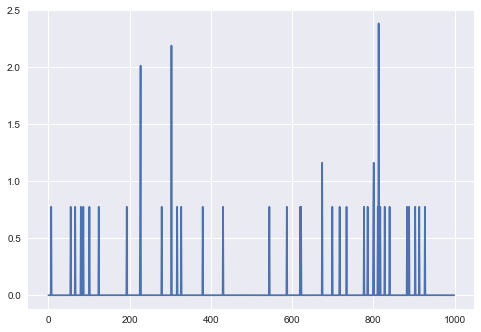

In [155]:
plt.plot(diferenca)